In [1]:
#import packages 📦 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image 
import skimage.io
import skimage.transform
from PIL import Image
import numpy as np
import seaborn as sns
import math
import copy
import tensorflow as tf
%matplotlib inline

In [2]:
#import more packages 📦 
import keras.backend as K
from keras import optimizers
from keras_vggface import utils
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.utils import decode_predictions
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.models import Sequential
from sklearn.metrics import confusion_matrix

In [3]:
K.clear_session()

In [4]:
#Vgg-face takes data in shape (224,224,3), the RGB channel is on the last axis,
K.set_image_data_format( 'channels_last' ) 
# nrow = 224
# ncol = 224
nrow=224
ncol=224

In [5]:
#load VGG Face
vggface = VGGFace(model='vgg16') 
vggface.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [6]:
#custom parameters
# 3 Names, 3 classes
nb_class = 17
hidden_dim = 512

vgg_notop = VGGFace(include_top=False, input_shape=(nrow, ncol, 3), pooling='avg')
for layer in vgg_notop.layers:
    layer.trainable = False


last_layer = vgg_notop.get_layer('pool5').output

x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
x = Dropout(.5)(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)

custom_vgg_model = Model(vgg_notop.input, out)
custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [7]:
#training data set
batch_size = 8

train_data_dir = '../converging_models/unmasked_dataset/train/'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 1360 images belonging to 17 classes.


In [8]:
#test data set
test_data_dir = '../converging_models/unmasked_dataset/test/'
test_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True
                                 )
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size, shuffle = False,
                        class_mode='sparse') 

Found 338 images belonging to 17 classes.


In [9]:
#display image function
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

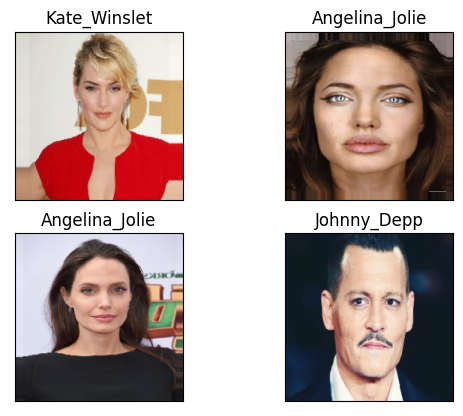

In [10]:
# names = ['Will Smith','Tom Hanks','Tom Cruise','Scarlett Johansson','Sandra Bullock',
#          'Robert Downey JR','Nicole Kidman','Natalie Portman','Megan Fox','Leo','Kate Winslet','Johnny Deep',
#         'Jennifier Lawrence','Hugh Jackman','Denzel Washington','Brad Pitt','Angelina Jolie']
names = ['Angelina_Jolie', 'Brad_Pitt', 'Denzel_Washington', 'Hugh_Jackman', 'Jennifer_Lawrence', 'Johnny_Depp', 'Kate_Winslet', 'Leonardo_DiCaprio', 'Megan_Fox', 'Natalie_Portman', 'Nicole_Kidman', 'Robert_Downey_Jr', 'Sandra_Bullock', 'Scarlett_Johansson', 'Tom_Cruise','Tom_Hanks', 'Will_Smith']


batch_shape = (batch_size,custom_vgg_model.input_shape[1] , 
               custom_vgg_model.input_shape[2], 
               custom_vgg_model.input_shape[3])
X = np.zeros(batch_shape)
y = np.zeros(batch_size)

X,y = train_generator.next()
nplot = 4        
for i in range(nplot):    
    plt.subplot(2,int(nplot/2),i+1)
    disp_image(X[i,:,:,:])
    title = (names[int(y[i])])
    plt.title(title)

In [11]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 verbose=1)

In [12]:
#train the model
custom_vgg_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
                         metrics=['accuracy'])

In [13]:
steps_per_epoch =  train_generator.n // batch_size
validation_steps =  test_generator.n // batch_size

nepochs = 40

history = custom_vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    callbacks=[cp_callback],
    validation_steps=validation_steps)

Epoch 1/40


C:\Users\chris\AppData\Local\Temp\ipykernel_12884\3118754905.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = custom_vgg_model.fit_generator(


85/85 [==============================] - ETA: 0s - loss: 2.8334 - accuracy: 0.0640
Epoch 1: val_accuracy improved from -inf to 0.06845, saving model to ./checkpoints\
85/85 [==============================] - 22s 212ms/step - loss: 2.8334 - accuracy: 0.0640 - val_loss: 2.8322 - val_accuracy: 0.0685
Epoch 2/40
85/85 [==============================] - ETA: 0s - loss: 2.8201 - accuracy: 0.0831
Epoch 2: val_accuracy improved from 0.06845 to 0.09524, saving model to ./checkpoints\
85/85 [==============================] - 17s 205ms/step - loss: 2.8201 - accuracy: 0.0831 - val_loss: 2.8227 - val_accuracy: 0.0952
Epoch 3/40
85/85 [==============================] - ETA: 0s - loss: 2.8139 - accuracy: 0.0926
Epoch 3: val_accuracy improved from 0.09524 to 0.10714, saving model to ./checkpoints\
85/85 [==============================] - 18s 212ms/step - loss: 2.8139 - accuracy: 0.0926 - val_loss: 2.8159 - val_accuracy: 0.1071
Epoch 4/40
85/85 [==============================] - ETA: 0s - loss: 2.7988 

KeyboardInterrupt: 

In [ ]:
custom_vgg_model.save('mask_face_model.h5')

In [ ]:
#Define functions to plot accuracy and loss
def plotAccuracy(history):

    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 
    
def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 

In [ ]:
#Run this cell to plot the new loss vs epoch graph
plotAccuracy(history)
plotLoss(history)

In [ ]:
names = [
        'Angelina_Jolie', 'Brad_Pitt', 'Denzel_Washington', 'Hugh_Jackman', 'Jennifer_Lawrence', 'Johnny_Depp', 'Kate_Winslet', 
        'Leonardo_DiCaprio', 'Megan_Fox', 'Natalie_Portman', 'Nicole_Kidman', 'Robert_Downey_Jr', 'Sandra_Bullock', 'Scarlett_Johansson', 
        'Tom_Cruise','Tom_Hanks', 'Will_Smith'
        ]

#Confusion Matrix 
plt.figure(figsize=(15, 5))

#Predict test images
Y_pred = custom_vgg_model.predict(test_generator)

#Get corresponding predicted label
y_pred = np.argmax(Y_pred, axis=1)

cf = confusion_matrix(test_generator.classes, y_pred)

df_cm = pd.DataFrame(cf, index=names, columns=names)

sns.heatmap(df_cm, annot= True,fmt="d",cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.title("Confusion matrix\n")
plt.show()

In [ ]:
import face_recognition
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
#grab preprocess from pre-trained model
from tensorflow.keras.applications.vgg19 import preprocess_input

# image1 = image.load_img("./data/Validation_long/female/113241.jpg.jpg", target_size = (180, 320))
image1 = image.load_img("../IN_YOUR_FACE_DATASET/UNMASKED_CELEBRITIES/Angelina_Jolie/Angelina_Jolie_047.jpg", target_size = (nrow, ncol))


transformedImage = image.img_to_array(image1)
transformedImage = np.expand_dims(transformedImage, axis = 0)
transformedImage = utils.preprocess_input(transformedImage, version=1)

prediction = custom_vgg_model.predict(transformedImage)
print(names[np.argmax(prediction, axis=1)[0]])

In [ ]:
video_capture = cv2.VideoCapture(0)



# Initialize some variables
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True
predictionLabel = ''

while True:
    ret, frame = video_capture.read()

    if process_this_frame:
        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
        rgb_small_frame = small_frame[:, :, ::-1]
        face_locations = face_recognition.face_locations(rgb_small_frame)

        new_frame = cv2.resize(frame, (224,224))
        x = image.img_to_array(new_frame)
        x = np.expand_dims(x, axis=0)
        x = utils.preprocess_input(x, version=1) # or version=2
        prediction = custom_vgg_model.predict(x)
        predictionLabel = names[np.argmax(prediction, axis=1)[0]]

        ###

        

    #process_this_frame = not process_this_frame


    for (top, right, bottom, left) in face_locations:
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        cv2.rectangle(frame, (left - 10, top - 50), (right + 10, bottom + 50), (0, 0, 255), 2)
        cv2.rectangle(frame, (left-11, bottom + 50), (right + 11, bottom + 75), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, predictionLabel, (left - 6, bottom + 65), font, 0.5, (255, 255, 255), 1)

    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

In [ ]:
name=names[np.argmax(Y_pred[0])]
print(name)


